In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2, l1

In [2]:
df = pd.read_csv('./datasets/cleaned_data/shelters_with_stats.csv')

# Info

In [3]:
df.head()

,id,name,date_in,location,intake_type,condition,age_in,breed,color,date_out,...,breed_2,pure,obey,reps_lower,reps_upper,height_low_inches,height_high_inches,weight_low_lbs,weight_high_lbs,time_in_shelter
0,A047759,Oreo,2014-04-02 15:55:00,Austin (TX),surrender,normal,10.0,dachshund,Tricolor,2014-04-07 15:12:00,...,dachshund,1.0,0.500,26.0,40.0,7.000000,10.000000,16.000000,32.000000,4 days 23:17:00
1,A134067,Bandit,2013-11-16 09:02:00,12034 Research Blvd in Austin (TX),public_assist,injured,16.0,shetland sheepdog,Brown/White,2013-11-16 11:54:00,...,shetland sheepdog,1.0,0.950,1.0,4.0,17.941176,20.908497,42.934641,57.522876,0 days 02:52:00
2,A141142,Bettie,2013-11-16 14:46:00,Austin (TX),stray,aged,15.0,labrador retriever/pit bull,Black/White,2013-11-17 11:40:00,...,pit bull,0.0,0.825,8.5,14.5,19.000000,21.500000,47.500000,65.000000,0 days 20:54:00
3,A163459,Sasha,2014-11-14 15:11:00,Ih 35 And 41St St in Austin (TX),stray,normal,15.0,miniature schnauzer,Black/Gray,2014-11-14 19:28:00,...,miniature schnauzer,1.0,0.850,5.0,15.0,17.941176,20.908497,42.934641,57.522876,0 days 04:17:00
4,A165752,Pep,2014-09-15 11:28:00,Gatlin Gun Rd And Brodie in Austin (TX),stray,normal,15.0,lhasa apso,Brown/White,2014-09-15 16:35:00,...,lhasa apso,1.0,0.300,41.0,80.0,17.941176,20.908497,42.934641,57.522876,0 days 05:07:00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53513 entries, 0 to 53512
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  53513 non-null  object 
 1   name                53513 non-null  object 
 2   date_in             53513 non-null  object 
 3   location            53513 non-null  object 
 4   intake_type         53512 non-null  object 
 5   condition           53504 non-null  object 
 6   age_in              53513 non-null  float64
 7   breed               53513 non-null  object 
 8   color               53513 non-null  object 
 9   date_out            53513 non-null  object 
 10  dob                 53513 non-null  object 
 11  outcome             53513 non-null  object 
 12  age_out             53513 non-null  float64
 13  sex                 53513 non-null  int64  
 14  intact_in           53513 non-null  int64  
 15  intact_out          53513 non-null  int64  
 16  age 

# Minor changes, might have to remove once Gene's cleaning is done

In [5]:
# filter out deceased, missing, euthanasia, died, disposal, and missing outcomes
df = df[(df['outcome'] == 'adoption') | (df['outcome'] == 'transfer') | (df['outcome'] == 'return_owner')]

In [6]:
df.dropna(inplace=True)

In [7]:
# create new column for adoption
# 1 = adopted, 0 = owner_return or transfer
df['adopted'] = df['outcome'].map({'adoption':1, 'return_owner':0, 'transfer':0})

In [8]:
df['time_in_shelter'] = pd.to_timedelta(df['time_in_shelter'])
df['time_in_shelter'] = df['time_in_shelter'].dt.days

# Functions

In [9]:
# Function taken from lesson, created by Jeff
def plot_hist(hist):
    """ plot the results from neural net training 
    
    Args:
        hist (TF history object): The history of the training
    
    Returns: 
        None
    """
    
    plt.figure(figsize=(12, 8))

    plt.plot(hist.history['accuracy'], label='Train')
    plt.plot(hist.history['val_accuracy'], label='Validation')

    plt.title('NN Performance on Shelter Data', fontsize=25)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)


    plt.legend(fontsize=18);

# NN Model

In [10]:
X = df[
    [
        "pure",
        "obey",
        "reps_lower",
        "reps_upper",
        "height_low_inches",
        "height_high_inches",
        "weight_low_lbs",
        "weight_high_lbs",
        "age_in",
        "sex",
        # "intake_type",
        "intact_in",
    ]
]

y = df["adopted"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101, stratify=y)


In [11]:
y.value_counts(normalize=True)

0    0.525015
1    0.474985
Name: adopted, dtype: float64

In [12]:
model = Sequential()

model.add(Dense(128, activation='relu', kernel_regularizer=l2(.001))),
model.add(Dropout(.25))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(.001))),
model.add(Dropout(.25))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(.001))),
model.add(Dropout(.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='bce', metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=20,
    callbacks=EarlyStopping(patience=5)
)

Epoch 1/20
597/597 [==============================] - 4s 5ms/step - loss: 0.8602 - accuracy: 0.5154 - val_loss: 0.7714 - val_accuracy: 0.5250
Epoch 2/20
597/597 [==============================] - 3s 5ms/step - loss: 0.7596 - accuracy: 0.5243 - val_loss: 0.7478 - val_accuracy: 0.5250
Epoch 3/20
597/597 [==============================] - 4s 6ms/step - loss: 0.7394 - accuracy: 0.5239 - val_loss: 0.7294 - val_accuracy: 0.5250
Epoch 4/20
597/597 [==============================] - 4s 6ms/step - loss: 0.7238 - accuracy: 0.5347 - val_loss: 0.7114 - val_accuracy: 0.5710
Epoch 5/20
597/597 [==============================] - 4s 7ms/step - loss: 0.7057 - accuracy: 0.5629 - val_loss: 0.6929 - val_accuracy: 0.5763
Epoch 6/20
597/597 [==============================] - 4s 6ms/step - loss: 0.6953 - accuracy: 0.5772 - val_loss: 0.6892 - val_accuracy: 0.5895
Epoch 7/20
597/597 [==============================] - 4s 6ms/step - loss: 0.6861 - accuracy: 0.5842 - val_loss: 0.6788 - val_accuracy: 0.5863
Epoch 

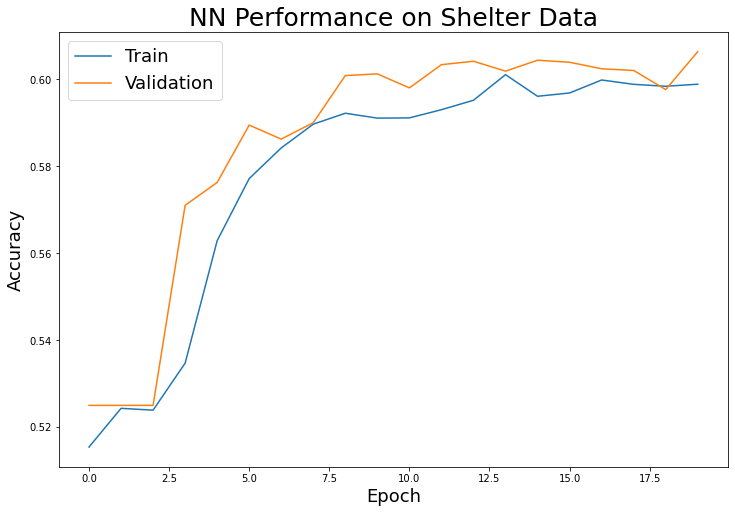

In [13]:
plot_hist(history)

# XGBClassifier

In [35]:
xgb = XGBClassifier(
    n_estimators=200, 
    use_label_encoder=False,
    eval_metric='logloss',      # what metric here?
    tree_method='gpu_hist', 
    gpu_id=0
)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.500000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=20,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [36]:
print('Train Score: ', xgb.score(X_train, y_train))
print('Train Score: ', xgb.score(X_test, y_test))

Train Score:  0.6620153415189675
Train Score:  0.6108536872693002
